<a href="https://colab.research.google.com/github/aditya2kahol/wandb-model-dev-course/blob/main/Assignment-1/Assignment_1_WandB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imagenette Classification

## Assignment 1

Author: Aditya Kahol

Download dataset from [here](https://course.fast.ai/datasets)

Dataset: Imagenette

Classes: 
  1. tench 
  2. English springer
  3. cassette player 
  4. chain saw
  5. church 
  6. French horn
  7. garbage truck
  8. gas pump
  9. golf ball
  10. parachute

In [ ]:
!pip install wandb --upgrade --quiet

     |████████████████████████████████| 1.8 MB 7.1 MB/s 
     |████████████████████████████████| 146 kB 63.0 MB/s 
     |████████████████████████████████| 181 kB 73.4 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 


## Data Loading

In [ ]:
#necessary imports
import os
import random
import tarfile
import matplotlib
import numpy as np
import pandas as pd
from skimage import io
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
import wandb

In [ ]:
#set seeds
torch.set_default_dtype(torch.float32)
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Download the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160.tgz"
download_url(dataset_url, '.')

  0%|          | 0/98752094 [00:00<?, ?it/s]

In [ ]:
os.listdir()

['.config', 'imagenette-160.tgz', 'sample_data']

In [ ]:
# Extract from archive
with tarfile.open('./imagenette-160.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [ ]:
PROJECT_NAME = 'imagenette-project'
ENTITY = None

In [ ]:
train_dir = './data/imagenette-160/train'
test_dir = './data/imagenette-160/val'

In [ ]:
#build dataset
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

dataset = ImageFolder(root = train_dir, 
                      transform = T.Compose([
                                             T.Resize((80,80)),
                                             T.ToTensor(),     
                                             T.Normalize(*stats, inplace = True)
                                             ])
                      )
test_dataset = ImageFolder(root = test_dir, 
                           transform = T.Compose([
                                                  T.Resize((80,80)),
                                                  T.ToTensor(), 
                                                  T.Normalize(*stats, inplace = True)
                           ]))

In [ ]:
print(f"Length of training set: {len(dataset)}")
print(f"Length of test set: {len(test_dataset)}")

Length of training set: 12894
Length of test set: 500


In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


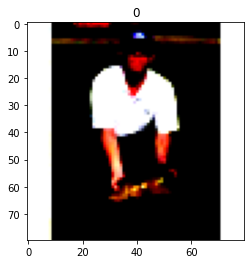

In [ ]:
img, label = dataset[0]
plt.imshow(img.permute(1,2,0))
plt.title(label)
plt.show()

In [ ]:
with wandb.init(project=PROJECT_NAME, entity=ENTITY, job_type="upload"):
  #create an artifact for all the raw data
  artifact_name = 'imagenette-dataset'
  artifact = wandb.Artifact(artifact_name, type='dataset')

  # Add a file to the artifact's contents
  artifact.add_file('imagenette-160.tgz')

  # Save the artifact version to W&B and mark it as the output of this run
  wandb.log_artifact(artifact)

## Training and Validation Datasets

In [ ]:
#set seed
random_seed = 1234
torch.manual_seed(random_seed);

#validation datasize
val_size = int(0.1*len(dataset))
train_size = len(dataset) - val_size

#create training and validation splits
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(11605, 1289)

### WandB table

```
class_name = ['Tench','English springer','Cassette player','Chainsaw','Church', 
'French horn','Garbage truck','Gas pump','Golf ball','Parachute']

def make_row(img, label):
  return [wandb.Image(img.permute(1,2,0).numpy()), label, class_name[label]]

make_row(*train_ds[0])
```
Log the first 50 training dataset as a Table

```
with wandb.init(project=PROJECT_NAME, entity=ENTITY, job_type="EDA") as run:    
  df = pd.DataFrame(data=[make_row(*train_ds[i]) for i in range(50)],
                    columns='Images,class-label,class-name'.split(','))
  run.log({'Table-imagenette-sample': wandb.Table(dataframe=df)})
```

In [ ]:
class_name = ['Tench','English springer','Cassette player','Chainsaw','Church', 
              'French horn','Garbage truck','Gas pump','Golf ball','Parachute']

def make_row(img, label):
  return [wandb.Image(img.permute(1,2,0).numpy()), label, class_name[label]]

#check make_row func
make_row(*train_ds[0])

[<wandb.sdk.data_types.image.Image at 0x7f5d048b3250>, 7, 'Gas pump']

In [ ]:
#Log the first 50 training dataset as a Table
with wandb.init(project=PROJECT_NAME, entity=ENTITY, job_type="EDA") as run:    
  df = pd.DataFrame(data=[make_row(*train_ds[i]) for i in range(50)],
                    columns='Transformed Images,class label,class name'.split(','))
  run.log({'Table-imagenette-sample': wandb.Table(dataframe=df)})

## Baseline Model Preparation

In [ ]:
#Prepare training and validation dataloaders
batch_size = 80
train_dl = DataLoader(dataset = train_ds,
                      shuffle = True,
                      batch_size = batch_size,
                      num_workers = 2,
                      pin_memory = True)
val_dl = DataLoader(dataset = val_ds,
                    batch_size = 2*batch_size,
                    num_workers = 2,
                    pin_memory = True)

In [ ]:
#Round function wrapper
R = np.round

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch 
    out = self(images)                  # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss

  def validation_step(self, batch):
    images, labels = batch 
    out = self(images)                    # Generate predictions
    loss = F.cross_entropy(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}
      
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    wandb.log({"epoch":epoch,"train loss":R(result['train_loss'],4), 
               "val loss":R(result['val_loss'],4), "val acc":R(result['val_acc'],4)})
    print(f"Epoch [{epoch}], train_loss: {R(result['train_loss'],4)}, val_loss: {R(result['val_loss'],4)}, val_acc: {R(result['val_acc'],4)}")

In [ ]:
class ImagenetteCnnModel(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        #input: 3,80,80
        nn.Conv2d(3, 32, kernel_size=3, stride = 1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        #output: 32,40,40
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), 
        #output: 30,20,20
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), 
        #output: 128,10,10
      
        nn.Flatten(),
        nn.Dropout(p = 0.2), 
        nn.Linear(128*10*10, 1000),
        nn.Dropout(p = 0.2),
        nn.ReLU(),
        nn.Linear(1000, 10))
      
  def forward(self, xb):
    return self.network(xb)

In [ ]:
model = ImagenetteCnnModel()
model

ImagenetteCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Dropout(p=0.2, inplace=False)
    (11): Linear(in_features=12800, out_features=1000, bias=True)
    (12): Dropout(p=0.2, inplace=False)
    (13): ReLU()
    (14): Linear(in_features=1000, out_features=10, bias=True)
  )
)

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([80, 3, 80, 80])
out.shape: torch.Size([80, 10])
out[0]: tensor([ 0.0704, -0.2976, -0.0798,  0.0800, -0.0758, -0.0079, -0.1026, -0.0446,
         0.0522,  0.0633], grad_fn=<SelectBackward0>)


In [ ]:
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')
    
def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
      
  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl: 
      yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

## Training

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, momentum, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr, momentum = momentum)
  wandb.watch(model)
  for epoch in range(epochs):
    # Training Phase 
    model.train()
    train_losses = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    # Validation phase
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [ ]:
base_model = to_device(model, device)
base_model

ImagenetteCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Dropout(p=0.2, inplace=False)
    (11): Linear(in_features=12800, out_features=1000, bias=True)
    (12): Dropout(p=0.2, inplace=False)
    (13): ReLU()
    (14): Linear(in_features=1000, out_features=10, bias=True)
  )
)

In [ ]:
evaluate(base_model, val_dl)

{'val_acc': 0.08927468955516815, 'val_loss': 2.3070454597473145}

In [ ]:
lr = 0.0009
epochs = 10
momentum = 0.88

In [ ]:
config_base = dict(
    batch_size = batch_size,
    learning_rate = lr,
    epochs = epochs,
    momentum = momentum,
    optimizer = 'sgd'
)

In [ ]:
with wandb.init(project=PROJECT_NAME, 
                entity=ENTITY, 
                config = config_base, 
                job_type="Baseline training"):
  history = fit(epochs, lr, momentum, model, train_dl, val_dl)

wandb: Currently logged in as: adi001. Use `wandb login --relogin` to force relogin


Epoch [0], train_loss: 2.2327, val_loss: 2.0977, val_acc: 0.3042
Epoch [1], train_loss: 2.0003, val_loss: 1.9185, val_acc: 0.34
Epoch [2], train_loss: 1.8387, val_loss: 1.7477, val_acc: 0.4133
Epoch [3], train_loss: 1.725, val_loss: 1.7015, val_acc: 0.4499
Epoch [4], train_loss: 1.6603, val_loss: 1.6126, val_acc: 0.4591
Epoch [5], train_loss: 1.5845, val_loss: 1.5674, val_acc: 0.4758
Epoch [6], train_loss: 1.5053, val_loss: 1.478, val_acc: 0.5056
Epoch [7], train_loss: 1.4335, val_loss: 1.4569, val_acc: 0.5015
Epoch [8], train_loss: 1.3804, val_loss: 1.4095, val_acc: 0.534
Epoch [9], train_loss: 1.3395, val_loss: 1.3744, val_acc: 0.5279


epoch,▁▂▃▃▄▅▆▆▇█
train loss,█▆▅▄▄▃▂▂▁▁
val acc,▁▂▄▅▆▆▇▇██
val loss,█▆▅▄▃▃▂▂▁▁
epoch,9
train loss,1.3395
val acc,0.5279
val loss,1.3744


In [ ]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs');

In [ ]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs');

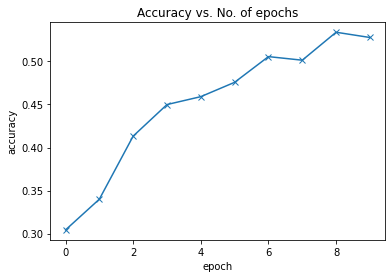

In [ ]:
plot_accuracies(history)

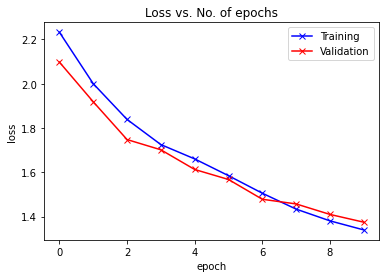

In [ ]:
plot_losses(history)

## Save the Model

In [ ]:
torch.save(model.state_dict(), 'imagenette-baseline_state_dict.pth')

<tt>Load the model with the following code</tt>
```
model_loaded = to_device(ImagenetteCnnModel(), device)
model_loaded.load_state_dict(torch.load('imagenette-cnn.pth'))
```

In [ ]:
with wandb.init(project = PROJECT_NAME, job_type = "Model weights", config = config_base):
  #create an artifact for all the raw data
  artifact_name = 'imagenette-baseline-model-state-dict'
  artifact = wandb.Artifact(artifact_name, type='baseline-weights')

  # Add a file to the artifact's contents
  artifact.add_file('imagenette-baseline_state_dict.pth')

  # Save the artifact version to W&B and mark it as the output of this run
  wandb.log_artifact(artifact)